# Загрузка датасета и первичный обзор

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# импортируем библиотеки
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# изображение -> вектор пикселей
pic_to_vec = transforms.Compose([
    transforms.ToTensor(),  # Преобразует в тензор (1, 28, 28)
    transforms.Lambda(lambda x: x.view(-1))  # Разворачивает в (784,)
])

# загружаем датасет
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=pic_to_vec, download=True)

# выделим валидацию
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.15, random_state=42)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=pic_to_vec, download=True)

# даталоадер
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
print(f"Размер валидации: {len(val_dataset)}")
print(f"Размер треина: {len(train_dataset)}")
print(f"Размер теста: {len(test_dataset)}")

Размер валидации: 9000
Размер треина: 51000
Размер теста: 10000


In [ ]:
print(f"Теперь объект это {type(train_dataset[0][0])} длиной {train_dataset[0][0].shape[0]}")
print(f"Таргет это {type(train_dataset[0][1])}")

Теперь объект это <class 'torch.Tensor'> длиной 784
Таргет это <class 'int'>


In [ ]:
import torch.nn as nn

# напишем базовую модель
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 256)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)

        return x

In [ ]:
model = Net()

In [ ]:
params_count = 0
for param in model.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 203530 параметров


In [ ]:
with torch.no_grad():
    x, y = train_dataset[0]  # Одно изображение и его метка
    x = x.view(1, -1)  # Делаем из (784,) → (n_batch, 784), добавляя batch размерности
    y_pred = model(x)

print(f"Сеть возвращает логиты: {y_pred}")

Сеть возвращает логиты: tensor([[ 0.0331,  0.0808, -0.0084, -0.0434,  0.0002,  0.1138, -0.1019,  0.0295,
          0.0854,  0.0917]])


А еще заведу словарик, куда буду добавлять отчеты по нейросетям

In [ ]:
research_info = {}

# Тренировочная функция с коллбеком

In [ ]:
from IPython.display import clear_output

# коллбек функция для отрисовки графика потери
def plot_callback(loss_history_train, loss_history_val):
    num_epoch = len(loss_history_train)
    epochs = np.arange(1, num_epoch + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss_history_train, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, loss_history_val, linestyle='-', color='r', label='Validation Loss')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)

    clear_output()  # очищаем предыдущий вывод в Colab

    plt.show()

In [ ]:
# функция тренировки модели с отрисовкой графика лосса
def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    train_loss_history = []
    val_loss_history = []

    fig = plt.figure(figsize=(8, 5))

    for epoch in range(num_epoch):
        model.train()
        epoch_train_loss = []

        # Обучение модели
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        mean_train_loss = np.mean(epoch_train_loss)
        train_loss_history.append(mean_train_loss)

        model.eval()
        epoch_val_loss = []

        # Оценка модели на валидационном наборе
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                epoch_val_loss.append(loss.item())

        mean_val_loss = np.mean(epoch_val_loss)
        val_loss_history.append(mean_val_loss)

        # Отрисовка графика
        plot_callback(train_loss_history, val_loss_history)

    min_loss = np.min(val_loss_history)

    return model, min_loss

# Базовая нейронная сеть без борьбы с переобучением

In [ ]:
# будем обучать много эпох
model_withno_reg = Net()

In [ ]:
# net summary
model_withno_reg

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
params_count = 0
for param in model_withno_reg.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 203530 параметров


In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_withno_reg = torch.optim.Adam(model_withno_reg.parameters())

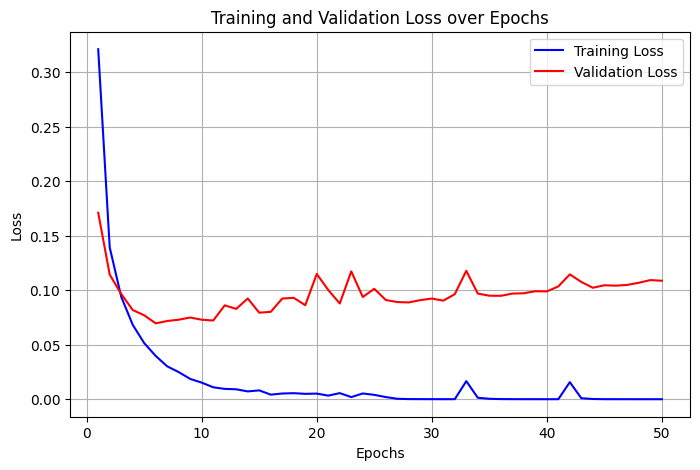

In [ ]:
model_withno_reg, min_loss_withno_reg = train(model_withno_reg, train_loader, val_loader, criterion, optimizer_withno_reg, 50)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_withno_reg.eval()

accuracy_base_withno_reg = 0
precision_base_withno_reg = 0
recall_base_withno_reg = 0
f1_base_withno_reg = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_withno_reg(X_batch), dim=1)
        accuracy_base_withno_reg += accuracy_score(y_pred, y_batch)
        precision_base_withno_reg += precision_score(y_pred, y_batch, average='macro')
        recall_base_withno_reg += recall_score(y_pred, y_batch, average='macro')
        f1_base_withno_reg += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_withno_reg /= k
precision_base_withno_reg /= k
recall_base_withno_reg /= k
f1_base_withno_reg /= k

new_log = [
    accuracy_base_withno_reg,
    precision_base_withno_reg,
    recall_base_withno_reg,
    f1_base_withno_reg,
    min_loss_withno_reg,
    50
]

research_info['model_withno_reg'] = new_log

print(f"Данные для будущей таблички: {new_log}")

Данные для будущей таблички: [0.9811902866242038, 0.9811082494999694, 0.9804812402742343, 0.9789782654836061, 0.06957140027261371, 50]


Видим явное переобучение: примерно на 8ой эпохе лосс на валидации начал расти, хотя на трейне лосс падает. <p>
В идеале применить EarlyStopping алгоритм на валидации, чтобы сохранить веса в ее праймовом состоянии (8ая эпоха), но я просто обучу модель на +-8 эпох.

# Базовая нейронная сеть без борьбы с переобучением (меньше эпох)

In [ ]:
# будем обучать пока график лосса на валидации не поползет вверх
model_withno_reg_early = Net()

In [ ]:
# net summary
model_withno_reg_early

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
params_count = 0
for param in model_withno_reg_early.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 203530 параметров


In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_withno_reg_early = torch.optim.Adam(model_withno_reg_early.parameters())

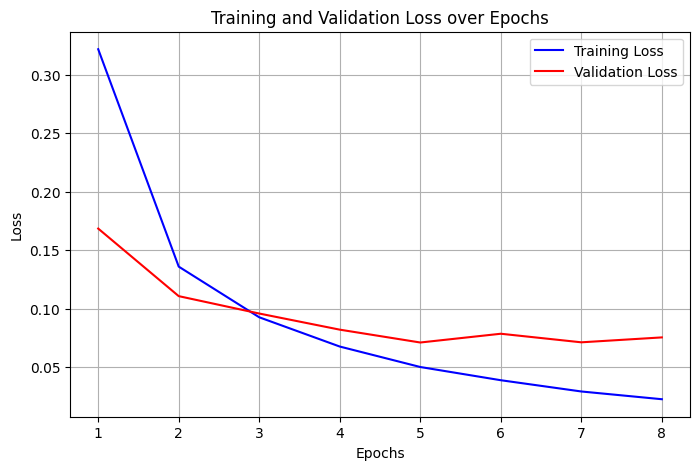

In [ ]:
model_withno_reg_early, min_loss_withno_reg_early = train(model_withno_reg_early, train_loader, val_loader, criterion, optimizer_withno_reg_early, 8)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_withno_reg_early.eval()

accuracy_base_withno_reg_early = 0
precision_base_withno_reg_early = 0
recall_base_withno_reg_early = 0
f1_base_withno_reg_early = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_withno_reg_early(X_batch), dim=1)
        accuracy_base_withno_reg_early += accuracy_score(y_pred, y_batch)
        precision_base_withno_reg_early += precision_score(y_pred, y_batch, average='macro')
        recall_base_withno_reg_early += recall_score(y_pred, y_batch, average='macro')
        f1_base_withno_reg_early += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_withno_reg_early /= k
precision_base_withno_reg_early /= k
recall_base_withno_reg_early /= k
f1_base_withno_reg_early /= k

new_log = [
    accuracy_base_withno_reg_early,
    precision_base_withno_reg_early,
    recall_base_withno_reg_early,
    f1_base_withno_reg_early,
    min_loss_withno_reg_early,
    8
]

research_info['model_withno_reg_early'] = new_log

print(f"Данные для будущей таблички: {new_log}")

Данные для будущей таблички: [0.977906050955414, 0.9778738518257063, 0.9783970211199516, 0.9760011952932518, 0.07091139207085502, 8]


# Нейронная сеть с Dropout (0.7)

In [ ]:
# напишем модель c dropout 0.7
class Net_dropout(nn.Module):
    def __init__(self):
        super(Net_dropout, self).__init__()

        self.drp = nn.Dropout(0.7)

        self.fc1 = nn.Linear(784, 256)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.drp(x)

        x = self.act1(x)

        x = self.fc2(x)

        return x

In [ ]:
model_drp = Net_dropout()

In [ ]:
# net summary
model_drp

Net_dropout(
  (drp): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
params_count = 0
for param in model_drp.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 203530 параметров


In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_drp = torch.optim.Adam(model_drp.parameters())

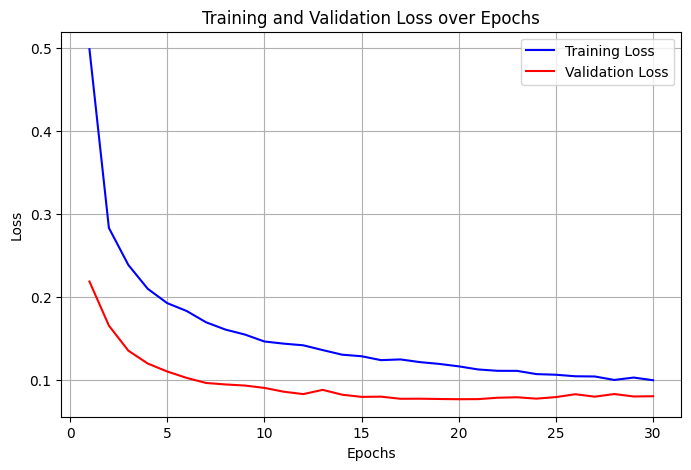

In [ ]:
model_drp, min_loss_drp = train(model_drp, train_loader, val_loader, criterion, optimizer_drp, 30)

На графике видим, что на валидации лосс не растет, хотя на трейне падает, то есть это говорит о том, что дропаут работает и модель не переобучается

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_drp.eval()

accuracy_base_drp = 0
precision_base_drp = 0
recall_base_drp = 0
f1_base_drp = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_drp(X_batch), dim=1)
        accuracy_base_drp += accuracy_score(y_pred, y_batch)
        precision_base_drp += precision_score(y_pred, y_batch, average='macro')
        recall_base_drp += recall_score(y_pred, y_batch, average='macro')
        f1_base_drp += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_drp /= k
precision_base_drp /= k
recall_base_drp /= k
f1_base_drp /= k

new_log = [
    accuracy_base_drp,
    precision_base_drp,
    recall_base_drp,
    f1_base_drp,
    min_loss_drp,
    8
]

research_info['model_drp'] = new_log

print(f"Данные для будущей таблички: {new_log}")

Данные для будущей таблички: [0.9793988853503185, 0.9789151636631964, 0.9798061298220536, 0.9772321688436693, 0.07639689394768248, 8]


# Нейронная сеть с Dropout (0.3)

In [ ]:
# напишем модель c dropout 0.7
class Net_dropout_low(nn.Module):
    def __init__(self):
        super(Net_dropout_low, self).__init__()

        self.drp = nn.Dropout(0.3)

        self.fc1 = nn.Linear(784, 256)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.drp(x)

        x = self.act1(x)

        x = self.fc2(x)

        return x

In [ ]:
model_drp_low = Net_dropout_low()

In [ ]:
# net summary
model_drp_low

Net_dropout_low(
  (drp): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
params_count = 0
for param in model_drp_low.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 203530 параметров


In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_drp_low = torch.optim.Adam(model_drp_low.parameters())

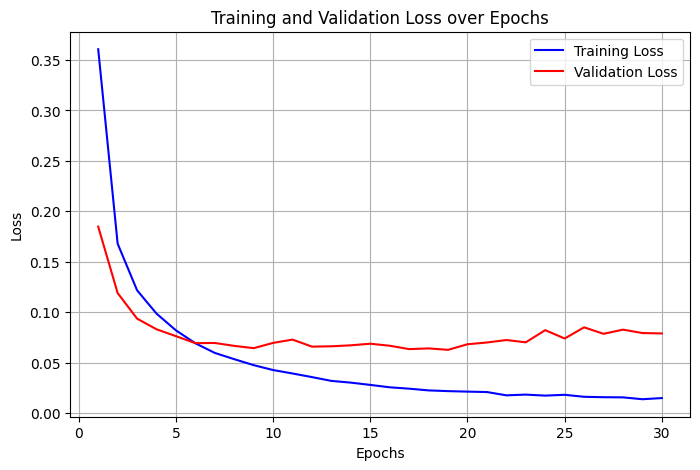

In [ ]:
model_drp_low, min_loss_drp_low = train(model_drp_low, train_loader, val_loader, criterion, optimizer_drp_low, 30)

По графику видно, что сначала модель хоть и переобучается, но медленно, походу ей недостаточно выключения лишь 0.3 нейронов (с 0.7 была ситуация лучше)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_drp_low.eval()

accuracy_base_drp_low = 0
precision_base_drp_low = 0
recall_base_drp_low = 0
f1_base_drp_low = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_drp_low(X_batch), dim=1)
        accuracy_base_drp_low += accuracy_score(y_pred, y_batch)
        precision_base_drp_low += precision_score(y_pred, y_batch, average='macro')
        recall_base_drp_low += recall_score(y_pred, y_batch, average='macro')
        f1_base_drp_low += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_drp_low /= k
precision_base_drp_low /= k
recall_base_drp_low /= k
f1_base_drp_low /= k

new_log = [
    accuracy_base_drp_low,
    precision_base_drp_low,
    recall_base_drp_low,
    f1_base_drp_low,
    min_loss_drp_low,
    30
]

research_info['model_drp_low'] = new_log

print(f"Данные для будущей таблички: {new_log}")

Данные для будущей таблички: [0.9818869426751592, 0.9819630057715488, 0.9817501076418276, 0.9802351444533822, 0.06264832278247923, 30]


# Нейронная сеть с BatchNorm

In [ ]:
# напишем модель c batchnorm
class Net_batchnorm(nn.Module):
    def __init__(self):
        super(Net_batchnorm, self).__init__()

        self.fc1 = nn.Linear(784, 256)
        self.btch = nn.BatchNorm1d(256)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.btch(x)

        x = self.act1(x)

        x = self.fc2(x)

        return x

In [ ]:
model_batch = Net_batchnorm()

In [ ]:
# net summary
model_batch

Net_batchnorm(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (btch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_batch = torch.optim.Adam(model_batch.parameters())

In [ ]:
params_count = 0
for param in model_batch.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 204042 параметров


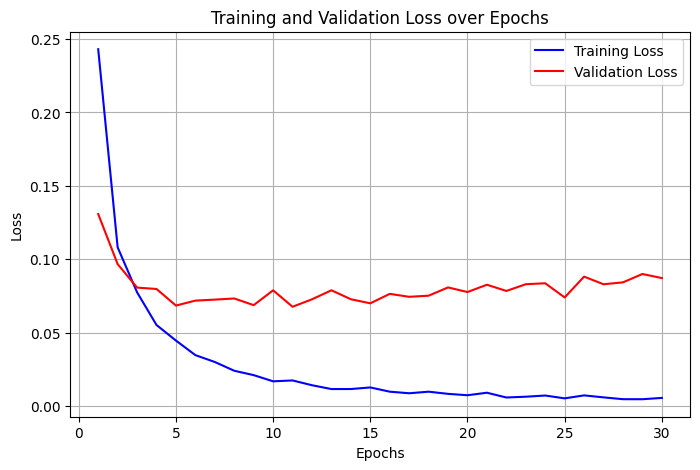

In [ ]:
model_batch, min_loss_batch = train(model_batch, train_loader, val_loader, criterion, optimizer_batch, 30)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_batch.eval()

accuracy_base_batch = 0
precision_base_batch = 0
recall_base_batch = 0
f1_base_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_batch(X_batch), dim=1)
        accuracy_base_batch += accuracy_score(y_pred, y_batch)
        precision_base_batch += precision_score(y_pred, y_batch, average='macro')
        recall_base_batch += recall_score(y_pred, y_batch, average='macro')
        f1_base_batch += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_batch /= k
precision_base_batch /= k
recall_base_batch /= k
f1_base_batch /= k

new_log = [
    accuracy_base_batch,
    precision_base_batch,
    recall_base_batch,
    f1_base_batch,
    min_loss_batch,
    30
]

research_info['model_batch'] = new_log

print(f"Данные для будущей таблички: {new_log}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Данные для будущей таблички: [0.9778065286624203, 0.9770708855899938, 0.9776278887425385, 0.9749707371955021, 0.06767281701999671, 30]


# Нейронная сеть с Dropout (0.3) и BatchNorm вместе + скрытый слой

In [ ]:
# напишем модель c dropout и batchnorm
class Net_batchnorm_dropout(nn.Module):
    def __init__(self):
        super(Net_batchnorm_dropout, self).__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.btch1 = nn.BatchNorm1d(256)
        self.btch2 = nn.BatchNorm1d(128)
        self.drp = nn.Dropout(0.3)
        self.act2 = nn.ReLU()
        self.act1 = nn.Tanh()

        self.fc3 = nn.Linear(128, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.btch1(x)
        x = self.act1(x)
        x = self.drp(x)

        x = self.fc2(x)
        x = self.btch2(x)
        x = self.act2(x)
        x = self.drp(x)

        x = self.fc3(x)

        return x

In [ ]:
model_batch_drop = Net_batchnorm_dropout()

In [ ]:
# net summary
model_batch_drop

Net_batchnorm_dropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (btch1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (btch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drp): Dropout(p=0.3, inplace=False)
  (act2): ReLU()
  (act1): Tanh()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_batch_drop = torch.optim.Adam(model_batch_drop.parameters())

In [ ]:
params_count = 0
for param in model_batch_drop.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 235914 параметров


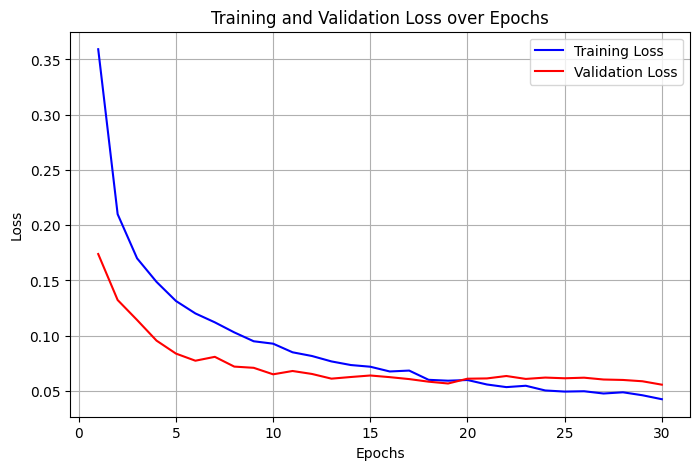

In [ ]:
model_batch_drop, min_loss_batch_drop = train(model_batch_drop, train_loader, val_loader, criterion, optimizer_batch_drop, 30)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_batch_drop.eval()

accuracy_base_batch_drop = 0
precision_base_batch_drop = 0
recall_base_batch_drop = 0
f1_base_batch_drop = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_batch_drop(X_batch), dim=1)
        accuracy_base_batch_drop += accuracy_score(y_pred, y_batch)
        precision_base_batch_drop += precision_score(y_pred, y_batch, average='macro')
        recall_base_batch_drop += recall_score(y_pred, y_batch, average='macro')
        f1_base_batch_drop += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_batch_drop /= k
precision_base_batch_drop /= k
recall_base_batch_drop /= k
f1_base_batch_drop /= k

new_log = [
    accuracy_base_batch_drop,
    precision_base_batch_drop,
    recall_base_batch_drop,
    f1_base_batch_drop,
    min_loss_batch_drop,
    30
]

research_info['model_batch_drop'] = new_log

print(f"Данные для будущей таблички: {new_log}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Данные для будущей таблички: [0.981687898089172, 0.9801423558748401, 0.9811670406734101, 0.9788138092863164, 0.05562845339869803, 30]


# Нейронная сеть с маленьким количеством параметров

In [ ]:
# напишем модель c dropout 0.3
class Net_few(nn.Module):
    def __init__(self):
        super(Net_few, self).__init__()

        self.drp = nn.Dropout(0.3)

        self.fc1 = nn.Linear(784, 8)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(8, 10)
        #self.act2 = nn.Softmax(dim=1) кросс-энтропия принимает логиты на вход

    def forward(self, x):
        x = self.fc1(x)
        x = self.drp(x)

        x = self.act1(x)

        x = self.fc2(x)

        return x

In [ ]:
model_few = Net_few()

In [ ]:
# net summary
model_few

Net_few(
  (drp): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=784, out_features=8, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=8, out_features=10, bias=True)
)

In [ ]:
# лосс-функция — кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()

# буду использовать Adam, он быстрее чем SGD
optimizer_few = torch.optim.Adam(model_few.parameters())

In [ ]:
params_count = 0
for param in model_few.parameters():
    params_count += torch.numel(param)
print(f"Сеть имеет {params_count} параметров")

Сеть имеет 6370 параметров


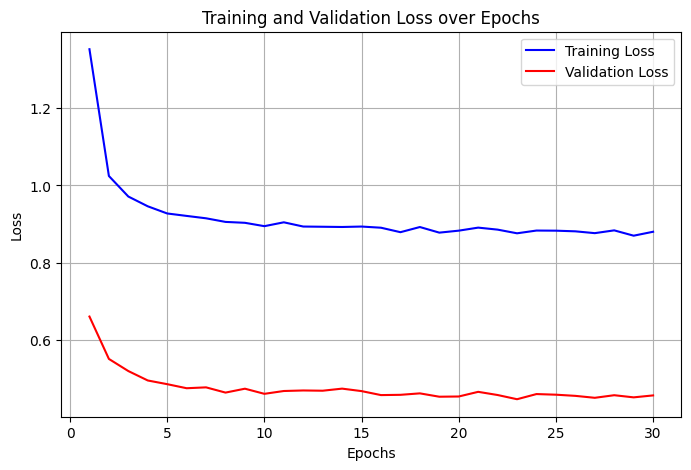

In [ ]:
model_few, min_loss_few = train(model_few, train_loader, val_loader, criterion, optimizer_few, 30)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_few.eval()

accuracy_base_few = 0
precision_base_few = 0
recall_base_few = 0
f1_base_few = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = torch.argmax(model_few(X_batch), dim=1)
        accuracy_base_few += accuracy_score(y_pred, y_batch)
        precision_base_few += precision_score(y_pred, y_batch, average='macro')
        recall_base_few += recall_score(y_pred, y_batch, average='macro')
        f1_base_few += f1_score(y_pred, y_batch, average='macro')

k = len(test_loader)

accuracy_base_few /= k
precision_base_few /= k
recall_base_few /= k
f1_base_few /= k

new_log = [
    accuracy_base_few,
    precision_base_few,
    recall_base_few,
    f1_base_few,
    min_loss_few,
    150
]

research_info['model_few'] = new_log

print(f"Данные для будущей таблички: {new_log}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Данные для будущей таблички: [0.8817675159235668, 0.8780904034144951, 0.8818173846677033, 0.8690805121487403, 0.447046789505803, 150]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Создание таблицы отчета

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = [
    "Номер эксперимента",
    "Мин. ошибка (валидация)",
    "Accuracy (тест)",
    "Precision (тест)",
    "Recall (тест)",
    "F1-score (тест)"
]

for i, exp in enumerate(research_info.values()):
    table.add_row([
        i + 1,
        f"{exp[4]:.3f}",
        f"{exp[0]:.3f}",
        f"{exp[1]:.3f}",
        f"{exp[2]:.3f}",
        f"{exp[3]:.3f}"
    ])

print(table)

+--------------------+-------------------------+-----------------+------------------+---------------+-----------------+
| Номер эксперимента | Мин. ошибка (валидация) | Accuracy (тест) | Precision (тест) | Recall (тест) | F1-score (тест) |
+--------------------+-------------------------+-----------------+------------------+---------------+-----------------+
|         1          |          0.070          |      0.981      |      0.981       |     0.980     |      0.979      |
|         2          |          0.071          |      0.978      |      0.978       |     0.978     |      0.976      |
|         3          |          0.076          |      0.979      |      0.979       |     0.980     |      0.977      |
|         4          |          0.063          |      0.982      |      0.982       |     0.982     |      0.980      |
|         5          |          0.068          |      0.978      |      0.977       |     0.978     |      0.975      |
|         6          |          0.056   

# Выводы по работе

1. Сравним первые 2 эксперимента: на первом получили скор лучше, хотя я делал обратное предположение (остановили обучение раньше, в точке где лосс на валидации меньше всего), видимо первой модели не хватило эпох, чтобы переобучиться и из-за этого скор примерно одиноковый <p>
А вообще для того чтобы вовремя остановить обучение в pytorch ignite есть специальный класс EarlyStopping
2. Сравним разные Dropout сети (3 и 4 эксперименты): видно, что на 4 скор лучше. Предполагаю это из-за того, что в 3-ем мы отключили слишком много нейронов и из-за этого модель недообучилась
3. Сравним 4 (лучший скор) и 6 (самая сложная модель) эксперименты: 6 модель это 4-ая + BatchNorm и дополнительный скрытый слой, как мы видим метрики одинаково хорошие, а значит можно сделать вывод, что BatchNorm и увелечение количества параметров не дали улучшений
4. Сравнивая модели с Dropout и без можно сразу увидеть, что с ним лосс не стремится расти, когда как без него о устремляется вверх
5. Как и ожидалось маленькое количество параметров (7) приводит к недообучению (возможно, если бы мы поставили очень много эпох она бы и обучилась, а возможно и нет), может маленькое количество параметров не позволяет нейросети выявлять сложные зависимости
6. BatchNorm не дал существенного эффекта, возможно из за того, что у нас значения и так в интервале [0, 1], то есть разброс фиксированный, а это уже в каком то плане нормализованные данные

Поставьте максимальный балл, пожалуйста ✨